In [146]:
import pandas as pd
import numpy as np

### データの読み込み

In [147]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [148]:
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [149]:
test.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


### 学習データを特徴量と目的変数に分ける

In [150]:
train_x = train.drop(['rainfall'],axis=1)
train_y = train['rainfall']

test_x = test.copy()

### データを調べる

データの方の確認

In [151]:
train_x.dtypes
#objectの場合型が混在する

id                 int64
day                int64
pressure         float64
maxtemp          float64
temparature      float64
mintemp          float64
dewpoint         float64
humidity         float64
cloud            float64
sunshine         float64
winddirection    float64
windspeed        float64
dtype: object

In [152]:
train_x.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
dtype: int64

In [153]:
print(train_x["day"].describe())

count    2190.000000
mean      179.948402
std       105.203592
min         1.000000
25%        89.000000
50%       178.500000
75%       270.000000
max       365.000000
Name: day, dtype: float64


ヒストグラムを分布で確認

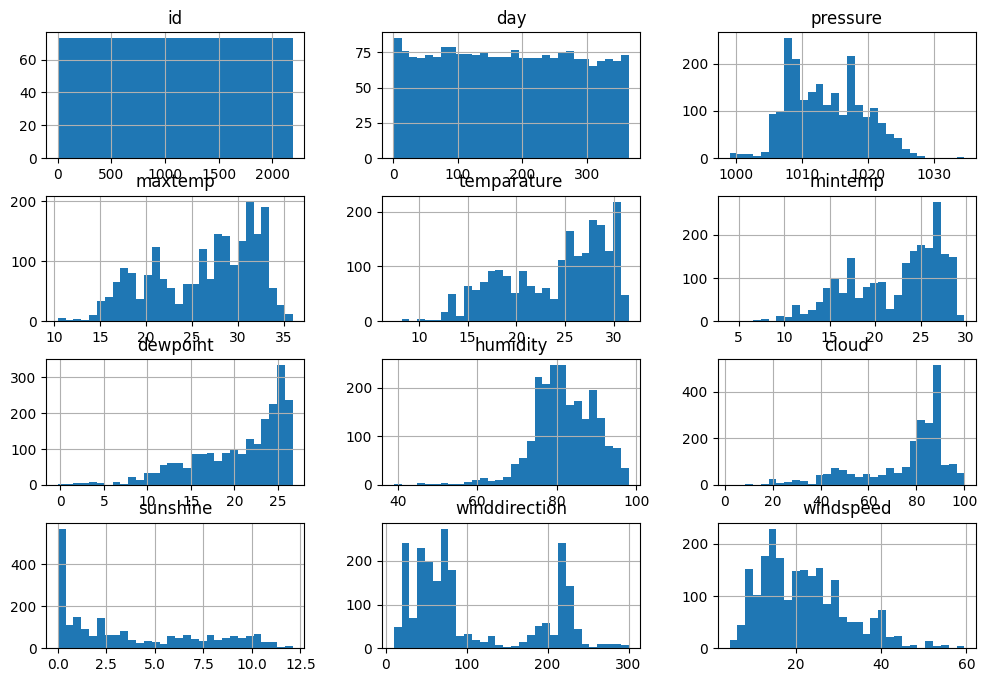

In [154]:
import matplotlib.pyplot as plt

train_x.hist(figsize=(12,8),bins=30)
plt.show()

### 変数の削除をする

In [155]:
# idの列は削除する
train_x = train_x.drop(['id'],axis=1)
test_x = test_x.drop(['id'],axis=1)

## 特徴量の作成

### 月の作成

In [156]:
# 1月1日を基準に日付に変換
train_x['date'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(train_x['day']-1,unit='D')
test_x['date'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(test_x['day']-1,unit='D')

# 月の数値を習得
train_x['month'] = train_x['date'].dt.month
test_x['month'] = test_x['date'].dt.month

#月の周期変換
train_x['month_sin'] = np.sin(2 * np.pi * train_x['month']/12)
train_x['month_cos'] = np.cos(2 * np.pi * train_x['month']/12)

test_x['month_sin'] = np.sin(2 * np.pi * test_x['month']/12)
test_x['month_cos'] = np.cos(2 * np.pi * test_x['month']/12)

# 不要な列を削除
train_x.drop(columns=['date'], inplace=True)
test_x.drop(columns=['date'], inplace=True)

print(train_x[['day','month','month_sin','month_cos']].head())

   day  month  month_sin  month_cos
0    1      1        0.5   0.866025
1    2      1        0.5   0.866025
2    3      1        0.5   0.866025
3    4      1        0.5   0.866025
4    5      1        0.5   0.866025


### 周期的な日の変換

In [157]:
train_x['day_sin'] = np.sin(2 * np.pi * train_x['day'] / 365)
train_x['day_cos'] = np.cos(2 * np.pi * train_x['day'] / 365)

test_x['day_sin'] = np.sin(2 * np.pi * test_x['day'] / 365)
test_x['day_cos'] = np.cos(2 * np.pi * test_x['day'] / 365)
print(train_x[['day','day_sin']].head())

   day   day_sin
0    1  0.017213
1    2  0.034422
2    3  0.051620
3    4  0.068802
4    5  0.085965


### 気温をmax<minとなっている列を欠損値とする

In [158]:
# maxtemp が mintemp 以下のデータをチェック
print(train_x[train_x['maxtemp'] <= train_x['mintemp']])

# 条件を満たす行の maxtemp を temperature で置き換える
train_x.loc[train_x['maxtemp'] <= train_x['mintemp'], 'maxtemp'] = train_x.loc[train_x['maxtemp'] <= train_x['mintemp'], 'temparature']
test_x.loc[test_x['maxtemp'] <= test_x['mintemp'], 'maxtemp'] = test_x.loc[test_x['maxtemp'] <= test_x['mintemp'], 'temparature']

      day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
319   320    1018.9     19.2         20.9     19.2      19.4      78.0   38.0   
1051  322    1016.8     19.3         21.6     19.4      15.8      70.0   83.0   

      sunshine  winddirection  windspeed  month  month_sin  month_cos  \
319        5.7           80.0       36.0     11       -0.5   0.866025   
1051       0.0           50.0       33.2     11       -0.5   0.866025   

       day_sin   day_cos  
319  -0.699458  0.714673  
1051 -0.674444  0.738326  


### 気温>最高気温となっている列を欠損値とする

In [159]:
# 修正前の異常データを確認
print("修正前の異常データ:")
print(train_x[train_x['temparature'] > train_x['maxtemp']])

# 異常データを temperature の値で置き換える
train_x.loc[train_x['maxtemp'] < train_x['temparature'], 'maxtemp'] = train_x.loc[train_x['maxtemp'] < train_x['temparature'], 'temparature']
test_x.loc[test_x['maxtemp'] < test_x['temparature'], 'maxtemp'] = test_x.loc[test_x['maxtemp'] < test_x['temparature'], 'temparature']

# 修正後のデータ確認
print("\n修正後の異常データ（空であることを確認）:")
print(train_x[train_x['temparature'] > train_x['maxtemp']])

修正前の異常データ:
      day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
1       2    1019.5     16.2         16.9     15.8      15.4      95.0   91.0   
12     13    1020.4     15.0         15.5     13.2      12.0      77.0   86.0   
369     5    1022.4     12.1         13.8     11.2       2.7      75.0   68.0   
398    34    1013.7     22.3         23.0     21.0      20.4      91.0   84.0   
653   289    1016.6     26.2         26.8     23.2      20.4      79.0   69.0   
702   338    1021.1     17.3         18.0     16.1      16.1      70.0   86.0   
734     5    1024.4     11.3         11.4     10.4       8.6      77.0   88.0   
796    67    1020.6     18.8         19.9     17.1      16.0      79.0   95.0   
1088  359    1025.9     17.5         18.0     16.5      13.3      79.0   89.0   
1104   10    1022.3     15.2         15.8     13.5      11.1      78.0   94.0   
1142   48    1013.3     17.1         17.2     15.2      14.8      87.0   90.0   
1146   52    1016

### 気温差

In [160]:
train_x['df_temp'] = train_x['maxtemp'] - train_x['mintemp']
test_x['df_temp'] = test_x['maxtemp'] - test_x['mintemp']

print(train_x[['maxtemp','mintemp','df_temp']])

      maxtemp  mintemp  df_temp
0        21.2     19.9      1.3
1        16.9     15.8      1.1
2        19.4     14.6      4.8
3        18.1     16.9      1.2
4        21.3     15.2      6.1
...       ...      ...      ...
2185     23.2     19.1      4.1
2186     17.3     16.3      1.0
2187     19.0     14.3      4.7
2188     16.4     13.8      2.6
2189     21.2     18.0      3.2

[2190 rows x 3 columns]


In [161]:
train_x

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,month,month_sin,month_cos,day_sin,day_cos,df_temp
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,5.000000e-01,0.866025,1.721336e-02,0.999852,1.3
1,2,1019.5,16.9,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,5.000000e-01,0.866025,3.442161e-02,0.999407,1.1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,5.000000e-01,0.866025,5.161967e-02,0.998667,4.8
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,5.000000e-01,0.866025,6.880243e-02,0.997630,1.2
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,1,5.000000e-01,0.866025,8.596480e-02,0.996298,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,12,-2.449294e-16,1.000000,-6.880243e-02,0.997630,4.1
2186,362,1012.4,17.3,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,12,-2.449294e-16,1.000000,-5.161967e-02,0.998667,1.0
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,12,-2.449294e-16,1.000000,-3.442161e-02,0.999407,4.7
2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,12,-2.449294e-16,1.000000,-1.721336e-02,0.999852,2.6


### 最低温度<露点温度

In [162]:
train_x['mintemp_dewpoint'] = train_x['mintemp'] < train_x['dewpoint']
train_x['mintemp_dewpoint'] = train_x['mintemp_dewpoint'].astype(int)

test_x['mintemp_dewpoint'] = test_x['mintemp'] < test_x['dewpoint']
test_x['mintemp_dewpoint'] = test_x['mintemp_dewpoint'].astype(int)


# 結果を確認
print(train_x[['mintemp','dewpoint', 'mintemp_dewpoint']].head())
print(train_x[train_x['mintemp_dewpoint']==1])

   mintemp  dewpoint  mintemp_dewpoint
0     19.9      19.4                 0
1     15.8      15.4                 0
2     14.6       9.3                 0
3     16.9      16.8                 0
4     15.2       9.6                 0
      day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
13     14    1012.5     13.5         12.9     11.6      11.8      87.0   92.0   
15     16    1024.3     15.3         12.9     10.0      11.2      79.0   91.0   
23     24    1013.0     24.8         19.9     17.1      18.1      90.0   92.0   
24     25    1012.5     23.8         22.2     20.4      20.8      84.0   88.0   
38     39    1023.1     20.4         17.8     14.8      15.0      75.0   43.0   
...   ...       ...      ...          ...      ...       ...       ...    ...   
2169  345    1016.3     16.5         16.5     15.8      16.6      91.0   83.0   
2170  346    1024.1     19.3         18.3     17.3      18.8      77.0   84.0   
2184  360    1015.8     20.9         

### 気温ー露点温度の関係

In [163]:
#湿度が高いと降水の可能性が高まる
train_x['temp_dewpoint_diff'] = train_x['temparature'] - train_x['dewpoint']
test_x['temp_dewpoint_diff'] = test_x['temparature'] - test_x['dewpoint']
print(train_x["temp_dewpoint_diff"])

0       1.2
1       1.5
2       6.8
3       1.0
4       8.8
       ... 
2185    0.7
2186    2.0
2187    3.7
2188    0.5
2189    1.1
Name: temp_dewpoint_diff, Length: 2190, dtype: float64


### 湿度*気圧の関係

In [164]:
#高湿度と低気圧が組み合わさると、降水の確率が高まる
train_x['humidity_pressure_interaction'] = train_x['humidity'] * train_x['pressure']
test_x['humidity_pressure_interaction'] = test_x['humidity'] * test_x['pressure']
print(train_x['humidity_pressure_interaction'])

0       88513.8
1       96852.5
2       76807.5
3       96273.0
4       53133.6
         ...   
2185    98416.2
2186    92128.4
2187    80050.7
2188    94051.6
2189    90228.2
Name: humidity_pressure_interaction, Length: 2190, dtype: float64


### 風速 * 風向きの関係

In [165]:
#風速が高いときに降水が発生しやすい場
train_x['wind_direction_speed'] = train_x['winddirection'] * train_x['windspeed']
test_x['wind_direction_speed'] = test_x['winddirection'] * test_x['windspeed']
print(train_x['wind_direction_speed'])

0       1032.0
1       1095.0
2       1267.0
3       2136.0
4        992.0
         ...  
2185     884.0
2186    1765.0
2187    1316.0
2188     720.0
2189    3360.0
Name: wind_direction_speed, Length: 2190, dtype: float64


### 月と日付の周期的な特徴量

In [166]:
#月ごとの温度差や、日ごとの温度変化を考慮した特徴量
train_x['month_day_interaction'] = train_x['month_sin'] * train_x['day_sin']
test_x['month_day_interaction'] = test_x['month_sin'] * test_x['day_sin']
print(train_x['month_day_interaction'])

0       8.606678e-03
1       1.721081e-02
2       2.580983e-02
3       3.440121e-02
4       4.298240e-02
            ...     
2185    1.685173e-17
2186    1.264317e-17
2187    8.430863e-18
2188    4.216056e-18
2189   -1.575506e-31
Name: month_day_interaction, Length: 2190, dtype: float64


### 風速*日照時間

In [167]:
#強い風と日照時間が長いと、乾燥した天気が続きやすい
train_x['windspeed_sunshine_interaction'] = train_x['windspeed'] * train_x['sunshine']
test_x['windspeed_sunshine_interaction'] = test_x['windspeed'] * test_x['sunshine']
print(train_x['windspeed_sunshine_interaction'])

0        18.92
1         0.00
2       150.23
3         0.00
4        89.28
         ...  
2185      2.21
2186      0.00
2187    164.50
2188      1.80
2189     48.00
Name: windspeed_sunshine_interaction, Length: 2190, dtype: float64


### 気温*湿度の関係

In [168]:
#気温と湿度が一緒に高い場合、降水の可能性が高い
train_x['temperature_humidity_interaction'] = train_x['temparature'] * train_x['humidity']
test_x['temperature_humidity_interaction'] = test_x['temparature'] * test_x['humidity']
print(train_x['temperature_humidity_interaction'])

0       1792.2
1       1605.5
2       1207.5
3       1691.0
4        956.8
         ...  
2185    1998.2
2186    1574.3
2187    1287.7
2188    1398.4
2189    1699.9
Name: temperature_humidity_interaction, Length: 2190, dtype: float64


### 気温と日照時間の関係

In [169]:
#高い気温と長い日照時間が同時に発生すると、特定の気象条件が発生しやすい
train_x['temperature_sunshine_interaction'] = train_x['temparature'] * train_x['sunshine']
test_x['temperature_sunshine_interaction'] = test_x['temparature'] * test_x['sunshine']
print(train_x['temperature_sunshine_interaction'])

0        22.66
1         0.00
2       133.63
3         0.00
4        66.24
         ...  
2185      2.06
2186      0.00
2187     81.50
2188      1.52
2189     19.10
Name: temperature_sunshine_interaction, Length: 2190, dtype: float64


### 気温と気圧の関係

In [170]:
#気圧が低いときに、暖かい空気が湿った状態であることが多い場合があります。
train_x['temperature_pressure_interaction'] = train_x['temparature'] * train_x['pressure']
test_x['temperature_pressure_interaction'] = test_x['temparature'] * test_x['pressure']
print(train_x['temperature_pressure_interaction'])

0       20958.44
1       17229.55
2       16488.01
3       18038.52
4       18801.12
          ...   
2185    20900.76
2186    17514.52
2187    16516.79
2188    15538.96
2189    19363.58
Name: temperature_pressure_interaction, Length: 2190, dtype: float64


### 風速と湿度の関係

In [171]:
train_x['windspeed_humidity_interaction'] = train_x['windspeed'] * train_x['humidity']
test_x['windspeed_humidity_interaction'] = test_x['windspeed'] * test_x['humidity']
print(train_x['windspeed_humidity_interaction'])

0       1496.4
1       2080.5
2       1357.5
3       3382.0
4       1289.6
         ...  
2185    2143.7
2186    3212.3
2187    2599.1
2188    1656.0
2189    4272.0
Name: windspeed_humidity_interaction, Length: 2190, dtype: float64


### 平均風速と気圧の関係

In [172]:
#強い風と低気圧が降水に関連する場合
train_x['pressure_windspeed_interaction'] = train_x['pressure'] * train_x['windspeed']
test_x['pressure_windspeed_interaction'] = test_x['pressure'] * test_x['windspeed']
print(train_x['pressure_windspeed_interaction'])

0       17499.28
1       22327.05
2       18536.21
3       36077.04
4       25340.64
          ...   
2185    22422.66
2186    35737.72
2187    33337.57
2188    18401.40
2189    48662.40
Name: pressure_windspeed_interaction, Length: 2190, dtype: float64


### 湿度と雲量の関係

In [173]:
#高湿度と多くの雲が同時に存在すると、降水が発生する
train_x['humidity_cloud_interaction'] = train_x['humidity'] * train_x['cloud']
test_x['humidity_cloud_interaction'] = test_x['humidity'] * test_x['cloud']
print(train_x['humidity_cloud_interaction'])

0       7656.0
1       8645.0
2       3525.0
3       9025.0
4       2340.0
         ...  
2185    8536.0
2186    8008.0
2187    6241.0
2188    8556.0
2189    7832.0
Name: humidity_cloud_interaction, Length: 2190, dtype: float64


### 湿度と露点温度の比率

In [174]:
#湿度が100%に近い場合、露点温度と気温が非常に近くなる
train_x['humidity_dewpoint_ratio'] = train_x['humidity'] / (train_x['dewpoint'] + 1)
test_x['humidity_dewpoint_ratio'] = test_x['humidity'] / (test_x['dewpoint'] + 1)
print(train_x['humidity_dewpoint_ratio'])

0       4.264706
1       5.792683
2       7.281553
3       5.337079
4       4.905660
          ...   
2185    4.641148
2186    5.582822
2187    5.808824
2188    5.859873
2189    4.684211
Name: humidity_dewpoint_ratio, Length: 2190, dtype: float64


### 湿度と日照時間の関係

In [175]:
train_x['humidity_sunshine_interaction'] = train_x['humidity'] * train_x['sunshine']
test_x['humidity_sunshine_interaction'] = test_x['humidity'] * test_x['sunshine']
print(train_x['humidity_sunshine_interaction'])

0        95.7
1         0.0
2       622.5
3         0.0
4       187.2
        ...  
2185      9.7
2186      0.0
2187    395.0
2188      9.2
2189     89.0
Name: humidity_sunshine_interaction, Length: 2190, dtype: float64


### 前日の日照時間の影響

In [176]:
#前日に日照時間（sunshine）が長かった場合、翌日も晴れる可能性が高くなります
train_x['prev_day_sunshine'] = (train_x['sunshine'].shift(1).fillna(0))
test_x['prev_day_sunshine'] = (test_x['sunshine'].shift(1).fillna(0))

### 湿度と気温の交差作用

In [177]:
train_x.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,windspeed_sunshine_interaction,temperature_humidity_interaction,temperature_sunshine_interaction,temperature_pressure_interaction,windspeed_humidity_interaction,pressure_windspeed_interaction,humidity_cloud_interaction,humidity_dewpoint_ratio,humidity_sunshine_interaction,prev_day_sunshine
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,18.92,1792.2,22.66,20958.44,1496.4,17499.28,7656.0,4.264706,95.7,0.0
1,2,1019.5,16.9,16.9,15.8,15.4,95.0,91.0,0.0,50.0,...,0.00,1605.5,0.00,17229.55,2080.5,22327.05,8645.0,5.792683,0.0,1.1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,150.23,1207.5,133.63,16488.01,1357.5,18536.21,3525.0,7.281553,622.5,0.0
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,...,0.00,1691.0,0.00,18038.52,3382.0,36077.04,9025.0,5.337079,0.0,8.3
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,...,89.28,956.8,66.24,18801.12,1289.6,25340.64,2340.0,4.905660,187.2,0.0


In [178]:
import pandas as pd

def convert_bool_to_int(df):
    # bool型のカラムを選択して変換
    bool_columns = df.select_dtypes(include=['bool']).columns
    df[bool_columns] = df[bool_columns].astype(int)
    return df

train_x = convert_bool_to_int(train_x)
#print(train_x)


In [179]:
train_x

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,windspeed_sunshine_interaction,temperature_humidity_interaction,temperature_sunshine_interaction,temperature_pressure_interaction,windspeed_humidity_interaction,pressure_windspeed_interaction,humidity_cloud_interaction,humidity_dewpoint_ratio,humidity_sunshine_interaction,prev_day_sunshine
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,18.92,1792.2,22.66,20958.44,1496.4,17499.28,7656.0,4.264706,95.7,0.0
1,2,1019.5,16.9,16.9,15.8,15.4,95.0,91.0,0.0,50.0,...,0.00,1605.5,0.00,17229.55,2080.5,22327.05,8645.0,5.792683,0.0,1.1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,150.23,1207.5,133.63,16488.01,1357.5,18536.21,3525.0,7.281553,622.5,0.0
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,...,0.00,1691.0,0.00,18038.52,3382.0,36077.04,9025.0,5.337079,0.0,8.3
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,...,89.28,956.8,66.24,18801.12,1289.6,25340.64,2340.0,4.905660,187.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,...,2.21,1998.2,2.06,20900.76,2143.7,22422.66,8536.0,4.641148,9.7,0.0
2186,362,1012.4,17.3,17.3,16.3,15.3,91.0,88.0,0.0,50.0,...,0.00,1574.3,0.00,17514.52,3212.3,35737.72,8008.0,5.582822,0.0,0.1
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,...,164.50,1287.7,81.50,16516.79,2599.1,33337.57,6241.0,5.808824,395.0,0.0
2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,...,1.80,1398.4,1.52,15538.96,1656.0,18401.40,8556.0,5.859873,9.2,5.0


In [180]:
#変数を削除するcos
dell = ['day','month','day','day_cos','month_cos']
train_x = train_x.drop(dell,axis=1)
test_x = test_x.drop(dell,axis=1)

In [181]:
train_x.isnull().sum()

pressure                            0
maxtemp                             0
temparature                         0
mintemp                             0
dewpoint                            0
humidity                            0
cloud                               0
sunshine                            0
winddirection                       0
windspeed                           0
month_sin                           0
day_sin                             0
df_temp                             0
mintemp_dewpoint                    0
temp_dewpoint_diff                  0
humidity_pressure_interaction       0
wind_direction_speed                0
month_day_interaction               0
windspeed_sunshine_interaction      0
temperature_humidity_interaction    0
temperature_sunshine_interaction    0
temperature_pressure_interaction    0
windspeed_humidity_interaction      0
pressure_windspeed_interaction      0
humidity_cloud_interaction          0
humidity_dewpoint_ratio             0
humidity_sun

In [182]:
# train_xの各列のデータ型を確認
print(train_x.dtypes)

# 数値に変換できない列を適切に処理
# 例えば、カテゴリカルな列をOneHotエンコーディングするなど
train_x = pd.get_dummies(train_x, drop_first=True)  # カテゴリカル変数をダミー変数に変換


pressure                            float64
maxtemp                             float64
temparature                         float64
mintemp                             float64
dewpoint                            float64
humidity                            float64
cloud                               float64
sunshine                            float64
winddirection                       float64
windspeed                           float64
month_sin                           float64
day_sin                             float64
df_temp                             float64
mintemp_dewpoint                      int64
temp_dewpoint_diff                  float64
humidity_pressure_interaction       float64
wind_direction_speed                float64
month_day_interaction               float64
windspeed_sunshine_interaction      float64
temperature_humidity_interaction    float64
temperature_sunshine_interaction    float64
temperature_pressure_interaction    float64
windspeed_humidity_interaction  

In [183]:
# 特徴量同士の内容が一致するかを比較
duplicates = []
for col1 in train_x.columns:
    for col2 in train_x.columns:
        if col1 != col2 and col1 not in duplicates and col2 not in duplicates:
            if train_x[col1].equals(train_x[col2]):
                duplicates.append(col1)
                duplicates.append(col2)

print("同じ内容の特徴量:", duplicates)


同じ内容の特徴量: []


### 相関関係の確認のコード

In [184]:
corr_matrix = train_x.corr()
print(corr_matrix)

                                  pressure   maxtemp  temparature   mintemp  \
pressure                          1.000000 -0.800680    -0.816531 -0.814453   
maxtemp                          -0.800680  1.000000     0.983468  0.965917   
temparature                      -0.816531  0.983468     1.000000  0.987150   
mintemp                          -0.814453  0.965917     0.987150  1.000000   
dewpoint                         -0.817008  0.906882     0.933617  0.941342   
humidity                         -0.119949 -0.073099    -0.025016  0.009891   
cloud                             0.098600 -0.289440    -0.249355 -0.219399   
sunshine                         -0.257163  0.452688     0.414019  0.379497   
winddirection                    -0.643293  0.662625     0.668963  0.663828   
windspeed                         0.266012 -0.354073    -0.342262 -0.328871   
month_sin                         0.173290 -0.357796    -0.356372 -0.351832   
day_sin                          -0.036606 -0.142588

In [185]:
train_x

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,...,windspeed_sunshine_interaction,temperature_humidity_interaction,temperature_sunshine_interaction,temperature_pressure_interaction,windspeed_humidity_interaction,pressure_windspeed_interaction,humidity_cloud_interaction,humidity_dewpoint_ratio,humidity_sunshine_interaction,prev_day_sunshine
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,...,18.92,1792.2,22.66,20958.44,1496.4,17499.28,7656.0,4.264706,95.7,0.0
1,1019.5,16.9,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,...,0.00,1605.5,0.00,17229.55,2080.5,22327.05,8645.0,5.792683,0.0,1.1
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,...,150.23,1207.5,133.63,16488.01,1357.5,18536.21,3525.0,7.281553,622.5,0.0
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,...,0.00,1691.0,0.00,18038.52,3382.0,36077.04,9025.0,5.337079,0.0,8.3
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,...,89.28,956.8,66.24,18801.12,1289.6,25340.64,2340.0,4.905660,187.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,...,2.21,1998.2,2.06,20900.76,2143.7,22422.66,8536.0,4.641148,9.7,0.0
2186,1012.4,17.3,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,...,0.00,1574.3,0.00,17514.52,3212.3,35737.72,8008.0,5.582822,0.0,0.1
2187,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,...,164.50,1287.7,81.50,16516.79,2599.1,33337.57,6241.0,5.808824,395.0,0.0
2188,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,...,1.80,1398.4,1.52,15538.96,1656.0,18401.40,8556.0,5.859873,9.2,5.0


In [186]:
# 相関行列の上三角部分を取得（対角成分と下三角は無視）
high_corr = corr_matrix.where((corr_matrix > 0.7) | (corr_matrix < -0.7))

# NaNを除外して表示
print(high_corr.dropna(how="all").dropna(axis=1, how="all"))


                                  pressure   maxtemp  temparature   mintemp  \
pressure                          1.000000 -0.800680    -0.816531 -0.814453   
maxtemp                          -0.800680  1.000000     0.983468  0.965917   
temparature                      -0.816531  0.983468     1.000000  0.987150   
mintemp                          -0.814453  0.965917     0.987150  1.000000   
dewpoint                         -0.817008  0.906882     0.933617  0.941342   
humidity                               NaN       NaN          NaN       NaN   
cloud                                  NaN       NaN          NaN       NaN   
sunshine                               NaN       NaN          NaN       NaN   
winddirection                          NaN       NaN          NaN       NaN   
windspeed                              NaN       NaN          NaN       NaN   
month_sin                              NaN       NaN          NaN       NaN   
day_sin                                NaN       NaN

### スケーリング

In [187]:
from sklearn.preprocessing import StandardScaler

# StandardScalerをインスタンス化
#scaler = StandardScaler()

# 訓練データのスケーリング
#train_x = scaler.fit_transform(train_x)

# テストデータのスケーリング（訓練データのスケーリングに基づく）
#test_x = scaler.transform(test_x)

In [188]:
train_x

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,...,windspeed_sunshine_interaction,temperature_humidity_interaction,temperature_sunshine_interaction,temperature_pressure_interaction,windspeed_humidity_interaction,pressure_windspeed_interaction,humidity_cloud_interaction,humidity_dewpoint_ratio,humidity_sunshine_interaction,prev_day_sunshine
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,...,18.92,1792.2,22.66,20958.44,1496.4,17499.28,7656.0,4.264706,95.7,0.0
1,1019.5,16.9,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,...,0.00,1605.5,0.00,17229.55,2080.5,22327.05,8645.0,5.792683,0.0,1.1
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,...,150.23,1207.5,133.63,16488.01,1357.5,18536.21,3525.0,7.281553,622.5,0.0
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,...,0.00,1691.0,0.00,18038.52,3382.0,36077.04,9025.0,5.337079,0.0,8.3
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,...,89.28,956.8,66.24,18801.12,1289.6,25340.64,2340.0,4.905660,187.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,...,2.21,1998.2,2.06,20900.76,2143.7,22422.66,8536.0,4.641148,9.7,0.0
2186,1012.4,17.3,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,...,0.00,1574.3,0.00,17514.52,3212.3,35737.72,8008.0,5.582822,0.0,0.1
2187,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,...,164.50,1287.7,81.50,16516.79,2599.1,33337.57,6241.0,5.808824,395.0,0.0
2188,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,...,1.80,1398.4,1.52,15538.96,1656.0,18401.40,8556.0,5.859873,9.2,5.0


In [189]:
print(train_x.shape[1])

28


In [190]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import json

# モデルの定義
class ImprovedNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # 追加層
        self.fc4 = nn.Linear(hidden_size, num_classes)  # 出力層
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(0.5)  # ドロップアウト
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)  # 出力層
        return x

# train_yをtorchのテンソルに変換
train_y = torch.tensor(train_y, dtype=torch.long)

# 標準化
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)  # test_xはtrain_xのスケーリングを使用

# NumPy配列をtorchテンソルに変換
train_x = torch.tensor(train_x, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)

# トレーニングデータの分割
batch_size = 2056
dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# モデルの初期化
input_size = train_x.shape[1]  # 特徴量の数
hidden_size = 1024 # 隠れ層のユニット数
num_classes = 2  # 0, 1の2クラス分類

model = ImprovedNN(input_size, hidden_size, num_classes)

# 重みの初期化
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

# 損失関数とオプティマイザ
learning_rate = 3e-4  # 学習率を適切に調整
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)

# 学習率スケジューラ
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 学習結果を保存するリスト
results = []

# モデルの訓練
num_epochs = 200
best_accuracy = 0.0
best_model_path = 'deep_model/best_model.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    results.append((epoch + 1, loss, accuracy))
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), best_model_path)  # 最良モデルを保存
    
    scheduler.step()

print(f"Best Model Saved with Accuracy: {best_accuracy:.2f}%")

# Accuracyの高い上位10個を抽出
results.sort(key=lambda x: x[2], reverse=True)
print("Top 10 Accuracy Results:")
for epoch, loss, accuracy in results[:10]:
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')

# 最良モデルをテストデータで評価
model.eval()
with torch.no_grad():
    test_outputs = model(test_x)
    _, predicted_classes = torch.max(test_outputs, 1)

# 結果を表示（テストデータでの予測されたクラスラベル）
print(f"Predicted classes for test_x: {predicted_classes}")


Best Model Saved with Accuracy: 87.17%
Top 10 Accuracy Results:
Epoch [104/200], Loss: 0.3130, Accuracy: 87.17%
Epoch [71/200], Loss: 0.3503, Accuracy: 87.08%
Epoch [169/200], Loss: 0.3336, Accuracy: 87.08%
Epoch [147/200], Loss: 0.3483, Accuracy: 87.03%
Epoch [96/200], Loss: 0.3267, Accuracy: 86.99%
Epoch [151/200], Loss: 0.3209, Accuracy: 86.99%
Epoch [126/200], Loss: 0.2947, Accuracy: 86.94%
Epoch [142/200], Loss: 0.3319, Accuracy: 86.94%
Epoch [178/200], Loss: 0.3207, Accuracy: 86.94%
Epoch [81/200], Loss: 0.3124, Accuracy: 86.89%
Predicted classes for test_x: tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 

In [199]:
import torch
import numpy as np

# モデルの予測を確率で取得
model.eval()
with torch.no_grad():
    test_outputs = model(test_x)
    test_probs = torch.softmax(test_outputs, dim=1)[:, 1]  # クラス1の確率を取得

# NumPy配列に変換
test_probs_np = test_probs.numpy()

# 結果を保存（加重平均で使えるように保存）
np.save('deep_model/test_probs.npy', test_probs_np)


In [198]:
import json  # ここでjsonモジュールをインポート
config = {
    'input_size': train_x.shape[1],  # 特徴量の数
    'hidden_size': 1024,  # 隠れ層のユニット数
    'num_classes': 2,  # クラスの数
    'learning_rate': 3e-4,  # 学習率
    'batch_size': 2056,  # バッチサイズ
    'num_epochs': 200  # エポック数
}

# config.json ファイルに保存
with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=4)

In [191]:
# 提出用ファイルの保存（例: 'submission.csv'）
# 提出用ファイルの作成
submission = pd.DataFrame({
    'id': test['id'], 
    'rainfall': predicted_classes
})
#submission.to_csv('deep_submit/submission_1.csv', index=False)

In [ ]:
"""
import optuna
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss

# ランダムシードを設定
np.random.seed(71)  # NumPyの乱数シード
import random
random.seed(71)  # Pythonのランダムシード

# 目的関数（評価指標: log_loss）
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'gamma': trial.suggest_float('gamma', 0, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 20),
        'random_state': 71,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # モデルの定義
    model = xgb.XGBClassifier(**params, n_jobs=-1)

    # 5分割クロスバリデーションで評価
    score = cross_val_score(model, train_x, train_y, scoring='neg_log_loss', cv=5, n_jobs=-1)
    
    return -1.0 * np.mean(score)  # log_loss は小さい方が良いので符号を反転

# Optuna でベイズ最適化
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  # 試行回数を500に増加

# 最適なパラメータ
best_params = study.best_params
print(f'最適なパラメータ: {best_params}')
#"""

"\nimport optuna\nimport numpy as np\nimport xgboost as xgb\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.metrics import log_loss\n\n# ランダムシードを設定\nnp.random.seed(71)  # NumPyの乱数シード\nimport random\nrandom.seed(71)  # Pythonのランダムシード\n\n# 目的関数（評価指標: log_loss）\ndef objective(trial):\n    params = {\n        'max_depth': trial.suggest_int('max_depth', 2, 15),\n        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),\n        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),\n        'subsample': trial.suggest_float('subsample', 0.3, 1.0),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),\n        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),\n        'gamma': trial.suggest_float('gamma', 0, 20),\n        'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),\n        'reg_lambda': trial.suggest_float('reg_lambda', 0, 20),\n        'random_state': 71,\n        'use_label_encod

In [ ]:
"""
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix

# モデルの作成と学習
model = xgb.XGBClassifier(**best_params, n_jobs=-1)
model.fit(train_x, train_y)

# テストデータで評価
y_pred_prob = model.predict_proba(train_x)  # 確率予測
logloss = log_loss(train_y, y_pred_prob)  # log_lossを計算

# 予測ラベルを取得
y_pred_label = model.predict(train_x)

# 正当率（accuracy）の計算
accuracy = accuracy_score(train_y, y_pred_label)

# その他の評価指標
precision = precision_score(train_y, y_pred_label, average='weighted')  # クラスごとに重み付き適合率
recall = recall_score(train_y, y_pred_label, average='weighted')  # クラスごとに重み付き再現率
f1 = f1_score(train_y, y_pred_label, average='weighted')  # クラスごとに重み付きF1スコア
conf_matrix = confusion_matrix(train_y, y_pred_label)  # 混同行列

# 結果を表示
print(f'Test Log Loss: {logloss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
#"""


"\nfrom sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix\n\n# モデルの作成と学習\nmodel = xgb.XGBClassifier(**best_params, n_jobs=-1)\nmodel.fit(train_x, train_y)\n\n# テストデータで評価\ny_pred_prob = model.predict_proba(train_x)  # 確率予測\nlogloss = log_loss(train_y, y_pred_prob)  # log_lossを計算\n\n# 予測ラベルを取得\ny_pred_label = model.predict(train_x)\n\n# 正当率（accuracy）の計算\naccuracy = accuracy_score(train_y, y_pred_label)\n\n# その他の評価指標\nprecision = precision_score(train_y, y_pred_label, average='weighted')  # クラスごとに重み付き適合率\nrecall = recall_score(train_y, y_pred_label, average='weighted')  # クラスごとに重み付き再現率\nf1 = f1_score(train_y, y_pred_label, average='weighted')  # クラスごとに重み付きF1スコア\nconf_matrix = confusion_matrix(train_y, y_pred_label)  # 混同行列\n\n# 結果を表示\nprint(f'Test Log Loss: {logloss:.4f}')\nprint(f'Test Accuracy: {accuracy:.4f}')\nprint(f'Test Precision: {precision:.4f}')\nprint(f'Test Recall: {recall:.4f}')\nprint(f'Test F1 Score: {f1:.4f}')\nprint

In [ ]:
""""
import shap
import matplotlib.pyplot as plt

# SHAPのExplainerを作成
explainer = shap.Explainer(model, train_x)

# SHAP値を計算
shap_values = explainer(train_x)

# 特徴量の重要度を可視化（サマリープロット）
shap.summary_plot(shap_values, train_x)

# 特定のサンプルについてSHAPの力価プロットを表示（例: 0番目のデータ）
shap.plots.waterfall(shap_values[0])
#"""

'"\nimport shap\nimport matplotlib.pyplot as plt\n\n# SHAPのExplainerを作成\nexplainer = shap.Explainer(model, train_x)\n\n# SHAP値を計算\nshap_values = explainer(train_x)\n\n# 特徴量の重要度を可視化（サマリープロット）\nshap.summary_plot(shap_values, train_x)\n\n# 特定のサンプルについてSHAPの力価プロットを表示（例: 0番目のデータ）\nshap.plots.waterfall(shap_values[0])\n#'

In [ ]:
"""
from sklearn.metrics import accuracy_score

# テストデータの予測確率を取得
pred_prob = model.predict_proba(test_x)[:, 1]

# 最適なしきい値を使用して予測値を二値に変換
#pred_label = np.where(pred_prob > best_threshold, 1, 0)
pred_label = np.where(pred_prob > 0.5, 1, 0)

# 提出用ファイルの作成
submission = pd.DataFrame({
    'id': test['id'], 
    'rainfall': pred_label
})

# 出力確認
print(submission)

# best['Survived']とpred_labelの1の数を比較
print("予測結果pred_labelの1の数:", pred_label.sum())
#"""

'\nfrom sklearn.metrics import accuracy_score\n\n# テストデータの予測確率を取得\npred_prob = model.predict_proba(test_x)[:, 1]\n\n# 最適なしきい値を使用して予測値を二値に変換\n#pred_label = np.where(pred_prob > best_threshold, 1, 0)\npred_label = np.where(pred_prob > 0.5, 1, 0)\n\n# 提出用ファイルの作成\nsubmission = pd.DataFrame({\n    \'id\': test[\'id\'], \n    \'rainfall\': pred_label\n})\n\n# 出力確認\nprint(submission)\n\n# best[\'Survived\']とpred_labelの1の数を比較\nprint("予測結果pred_labelの1の数:", pred_label.sum())\n#'

In [ ]:
import joblib

# 学習したモデルを保存
#joblib.dump(pred_prob, 'prodict_model/deep_model.pkl')

In [ ]:
# 提出用ファイルの保存（例: 'submission.csv'）
#submission.to_csv('submit/submission_5_4.csv', index=False)